In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_level_3 import optimization_level_3
from qco_spec_table import make_spec_table_loop, show_circuit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
[ds] = qml.data.load("ketgpt")

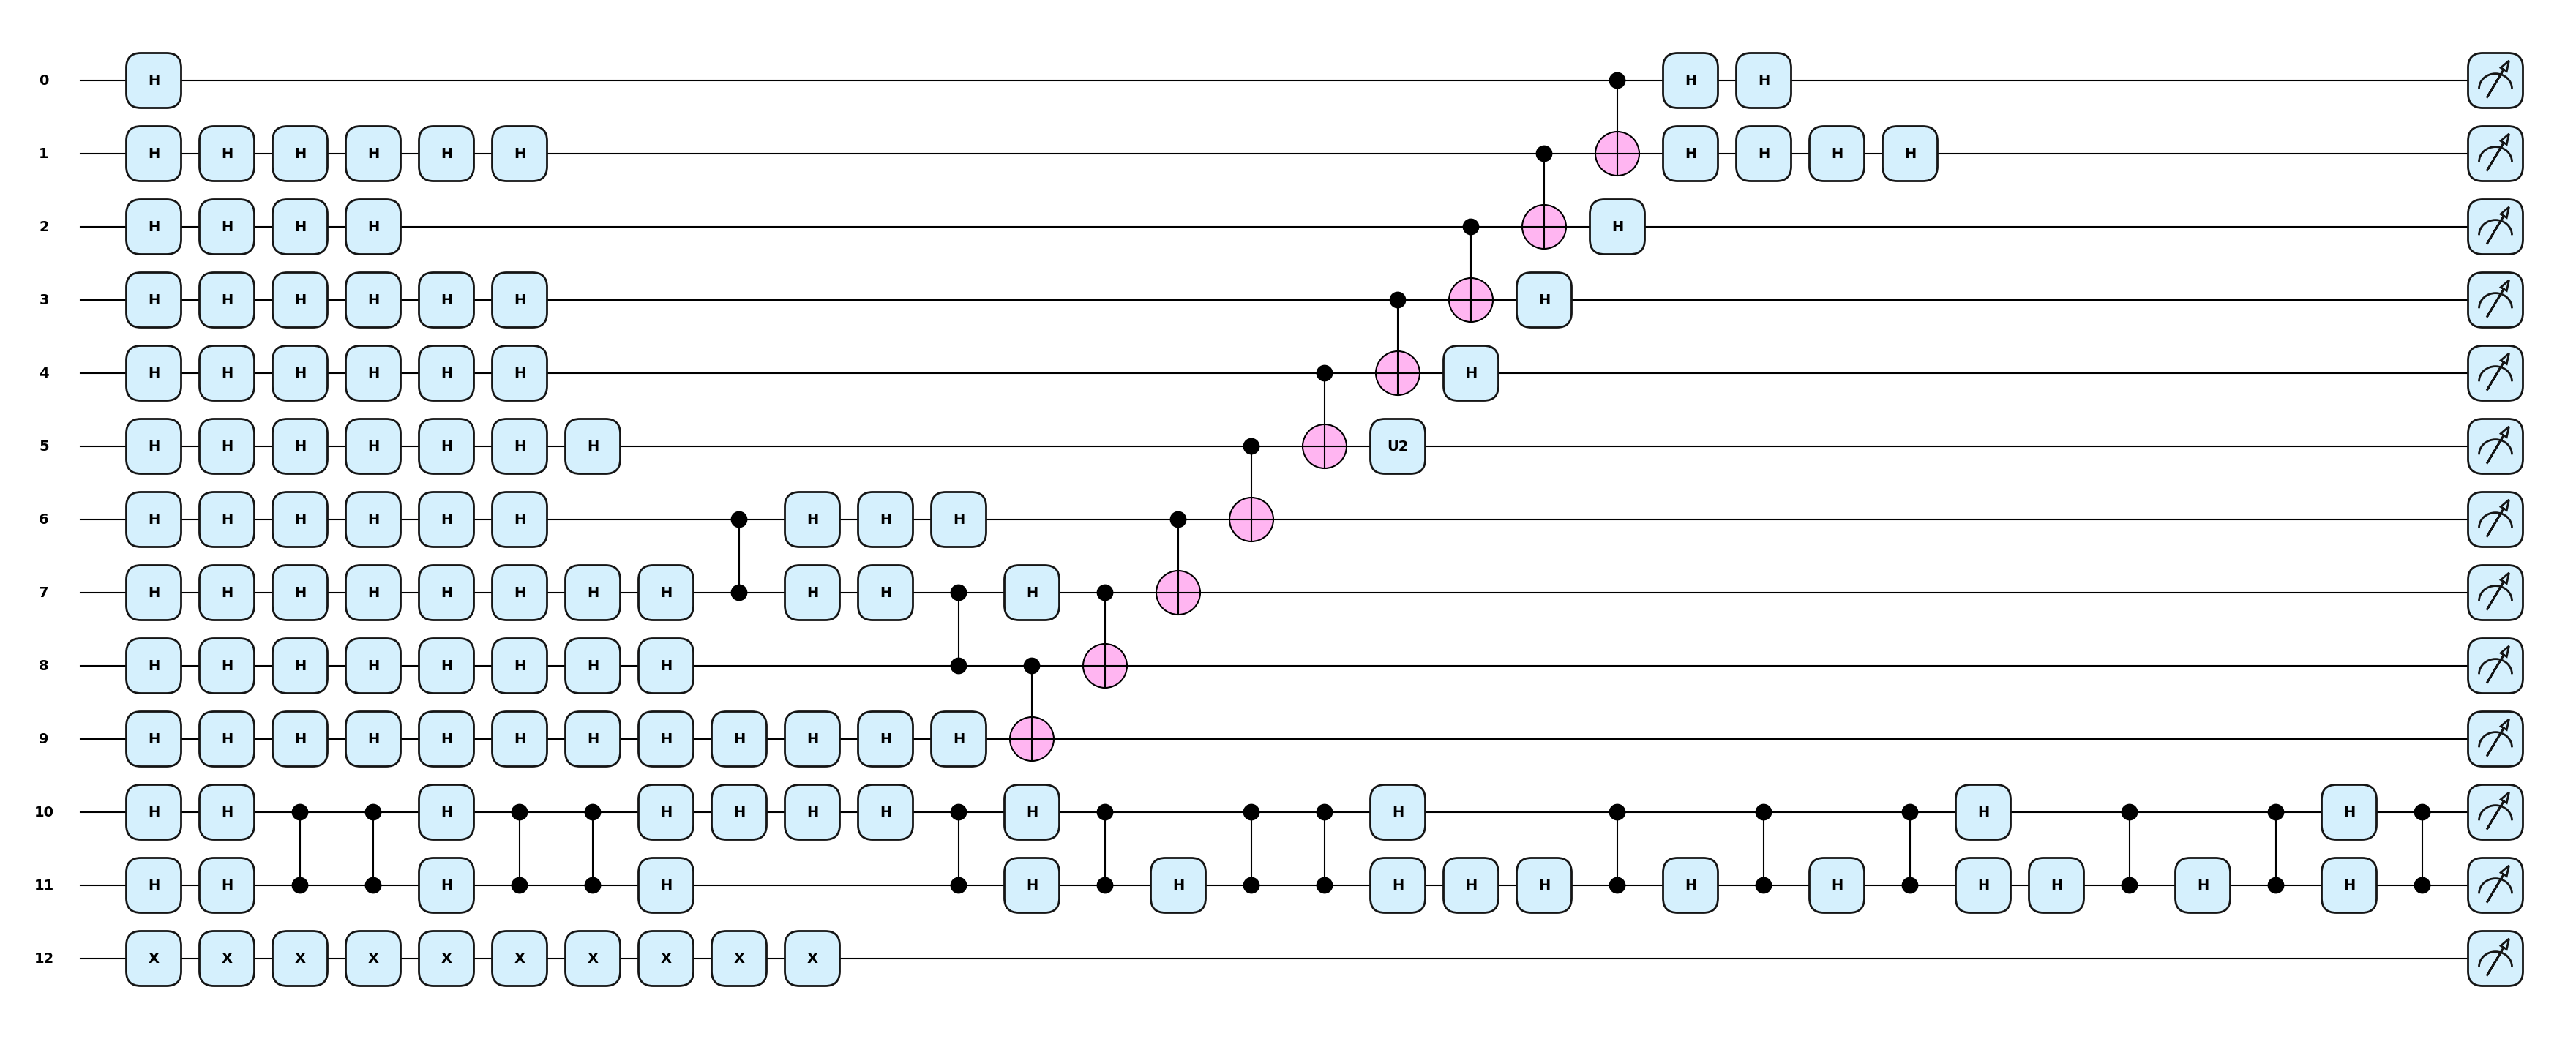

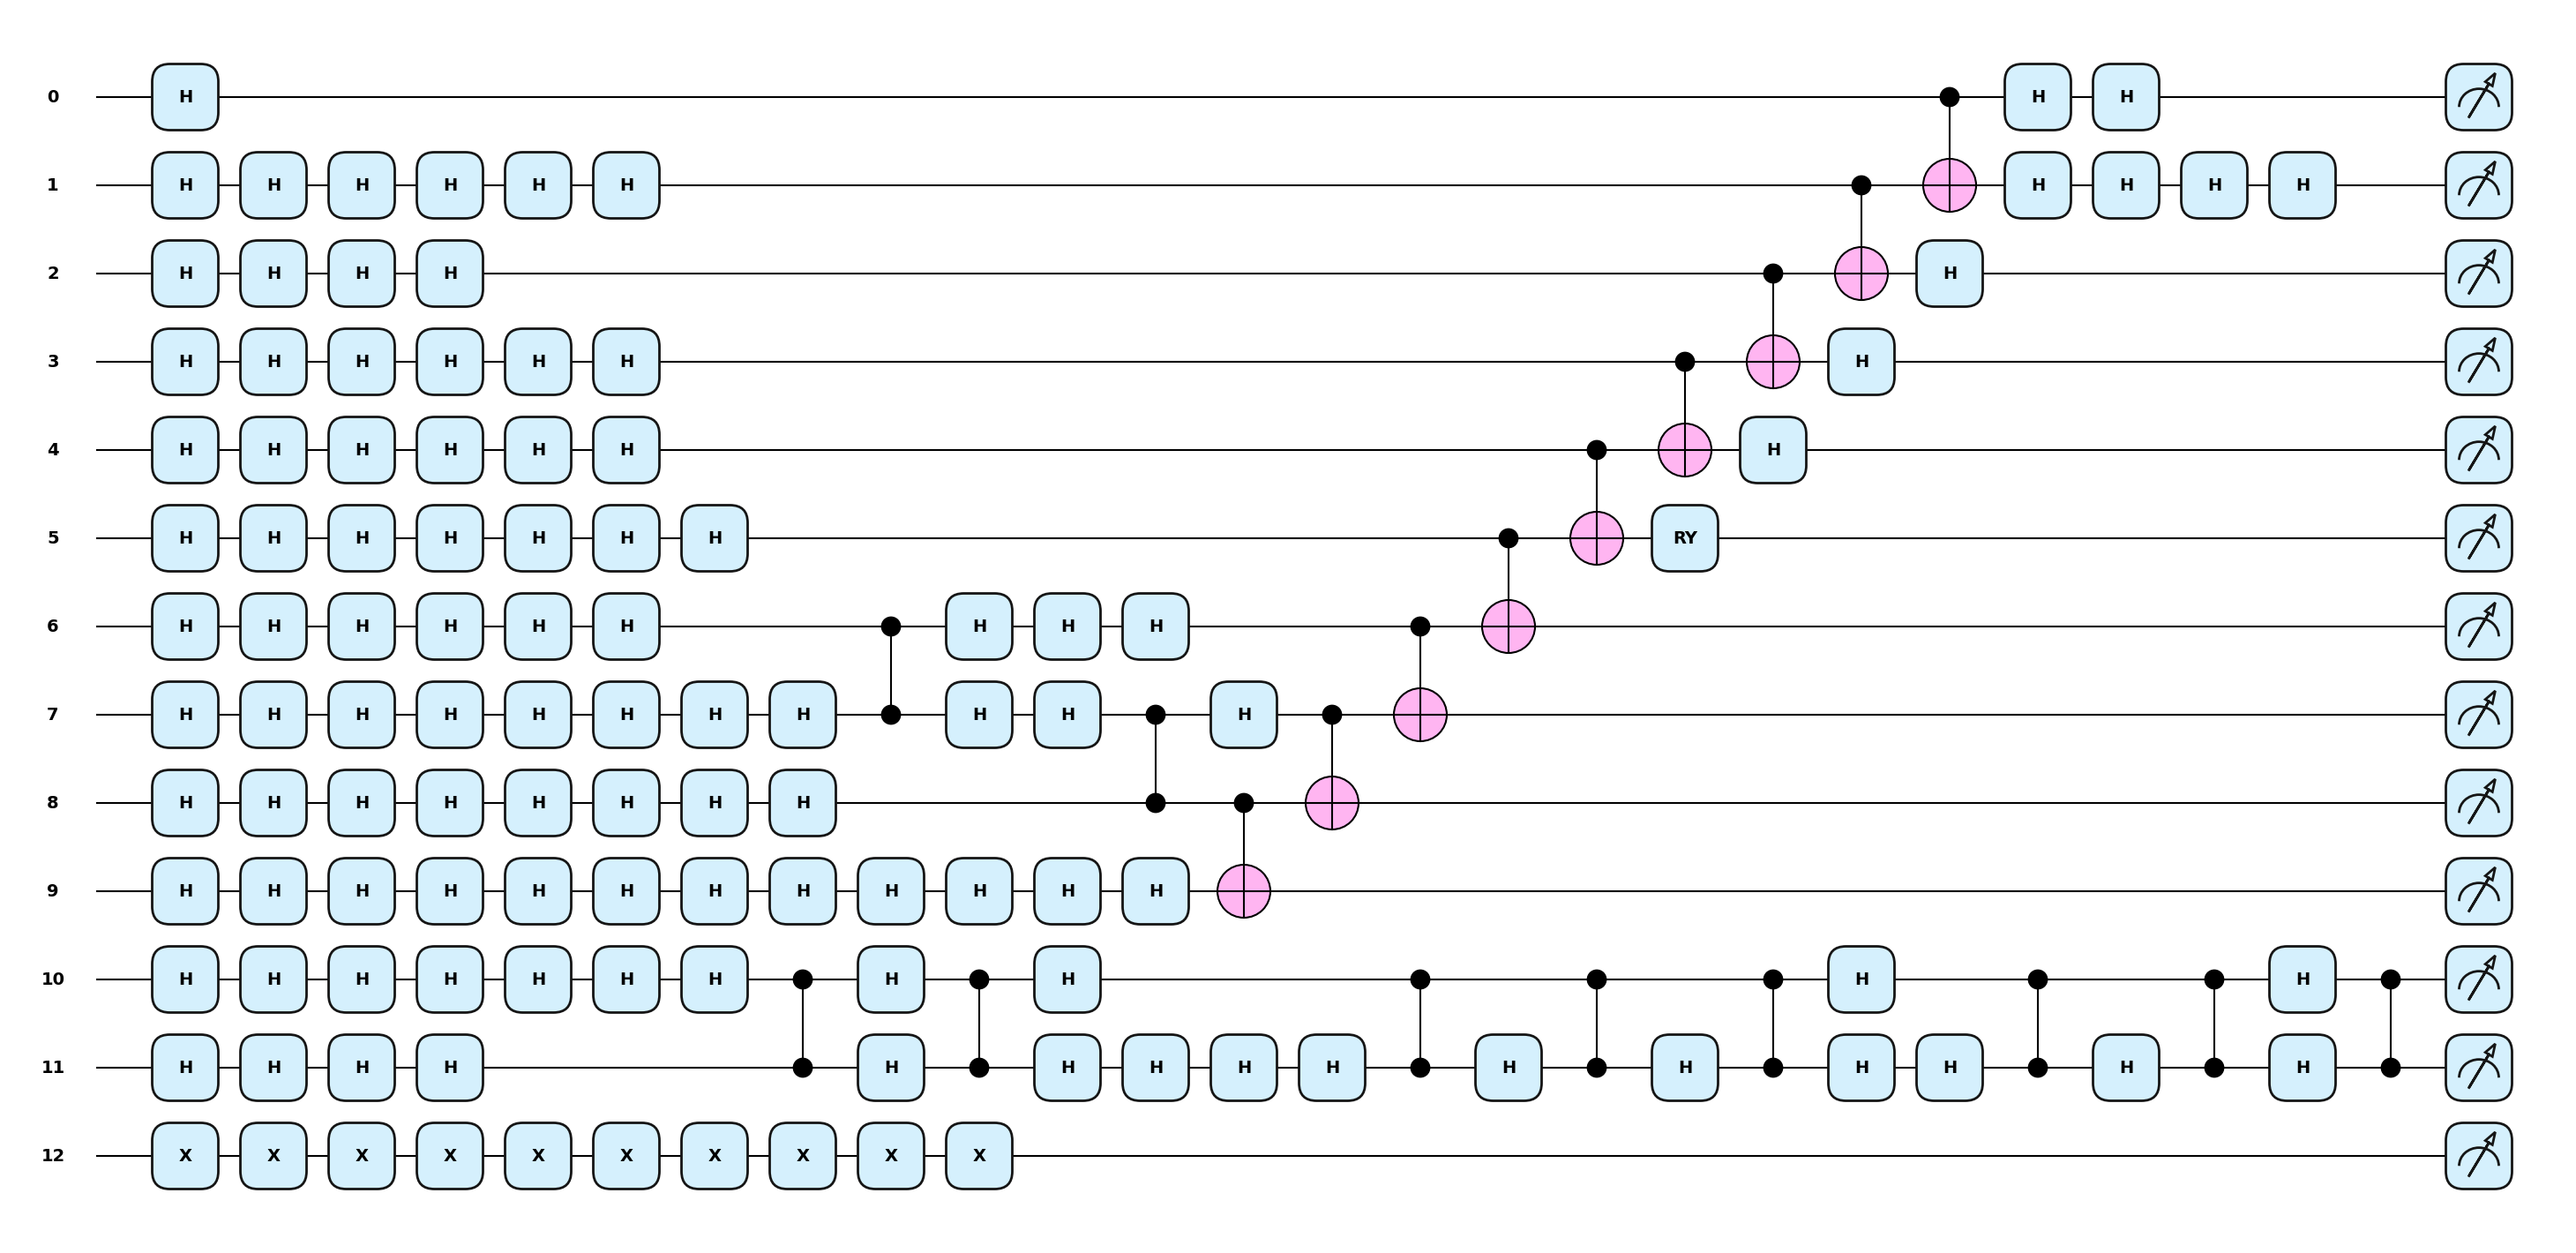

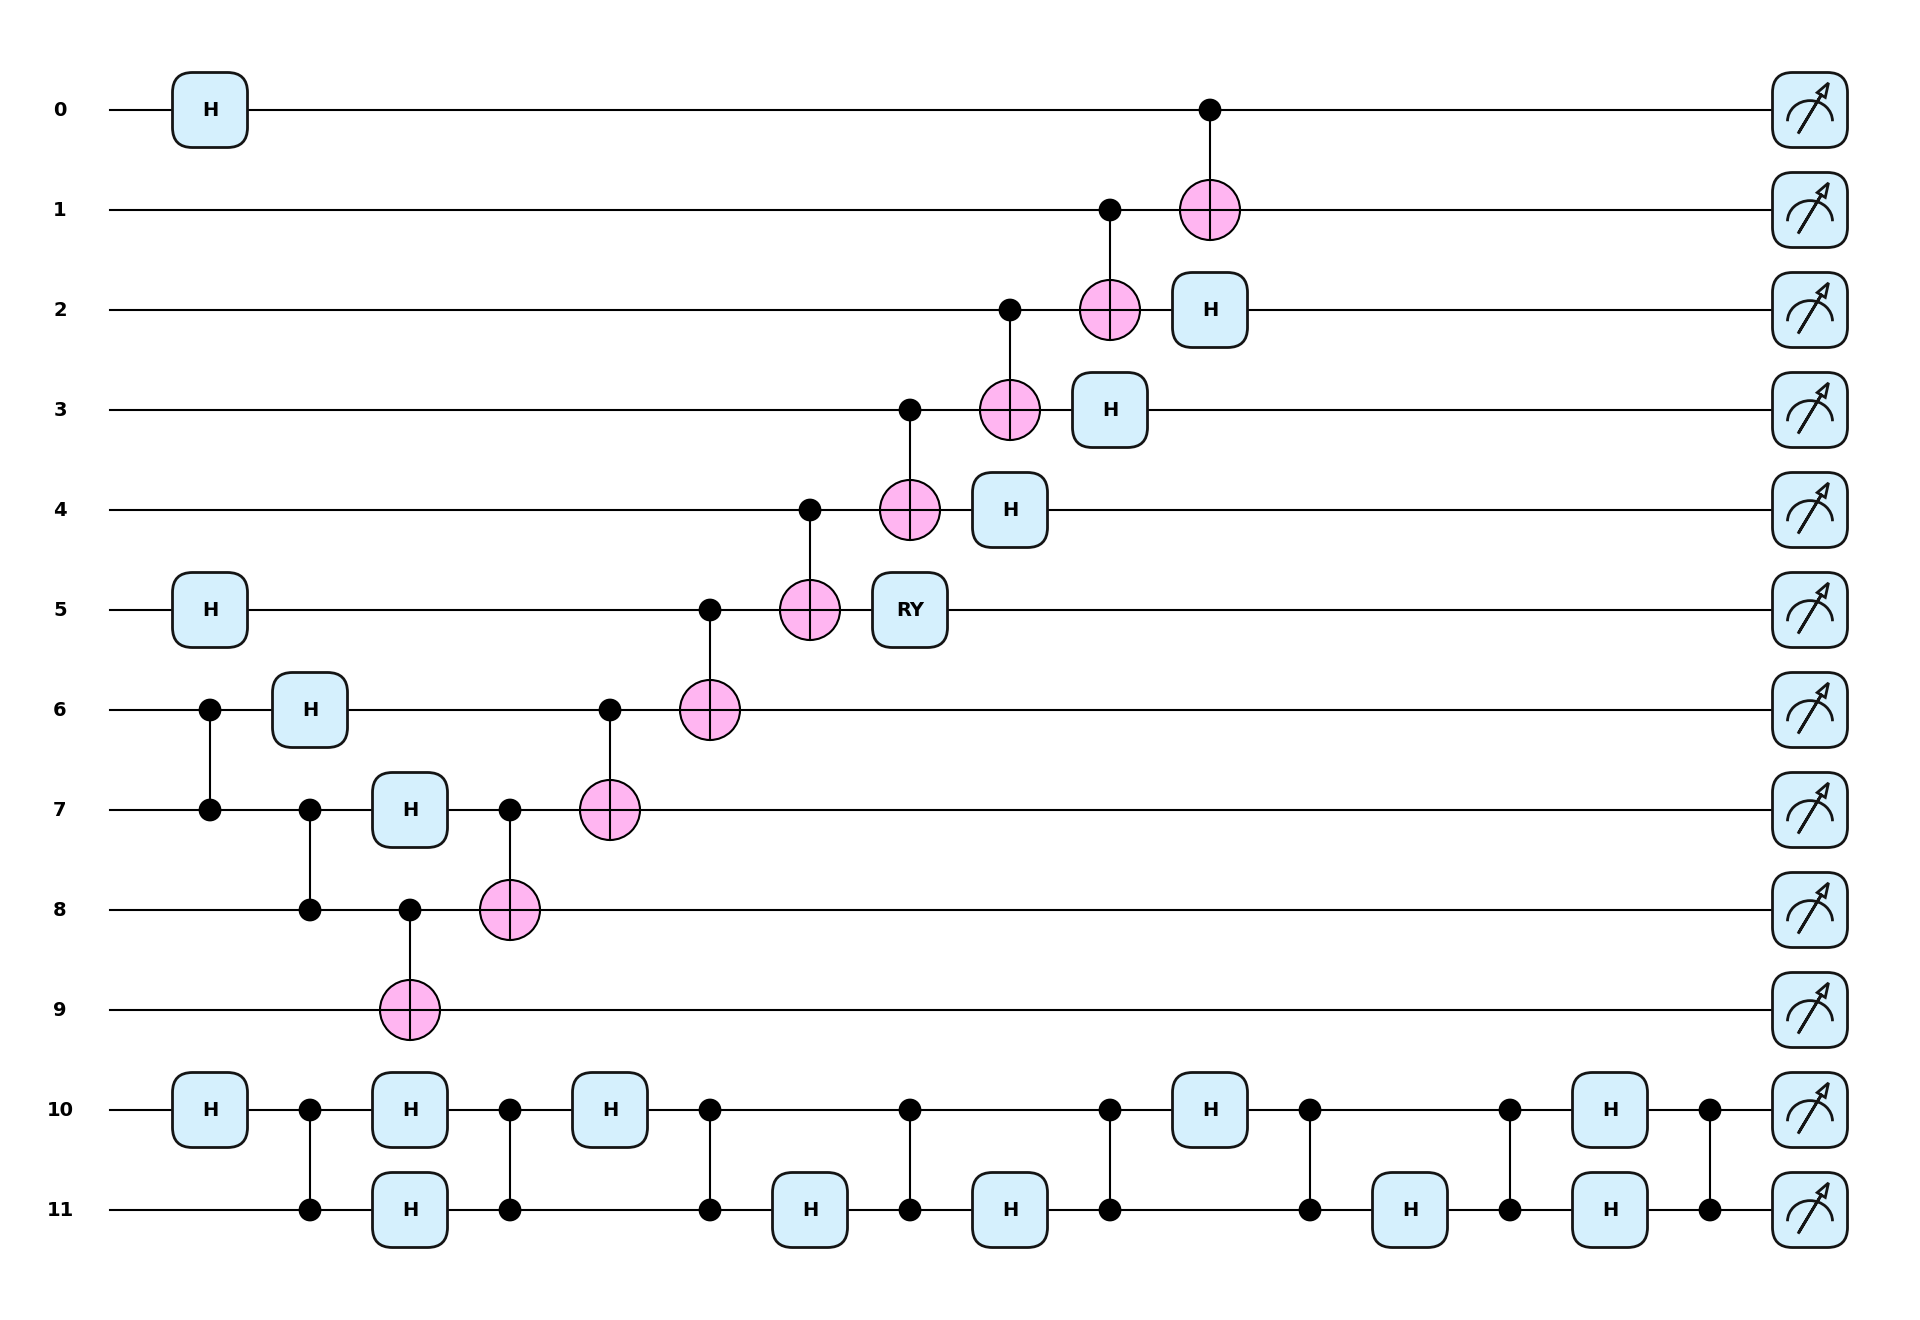

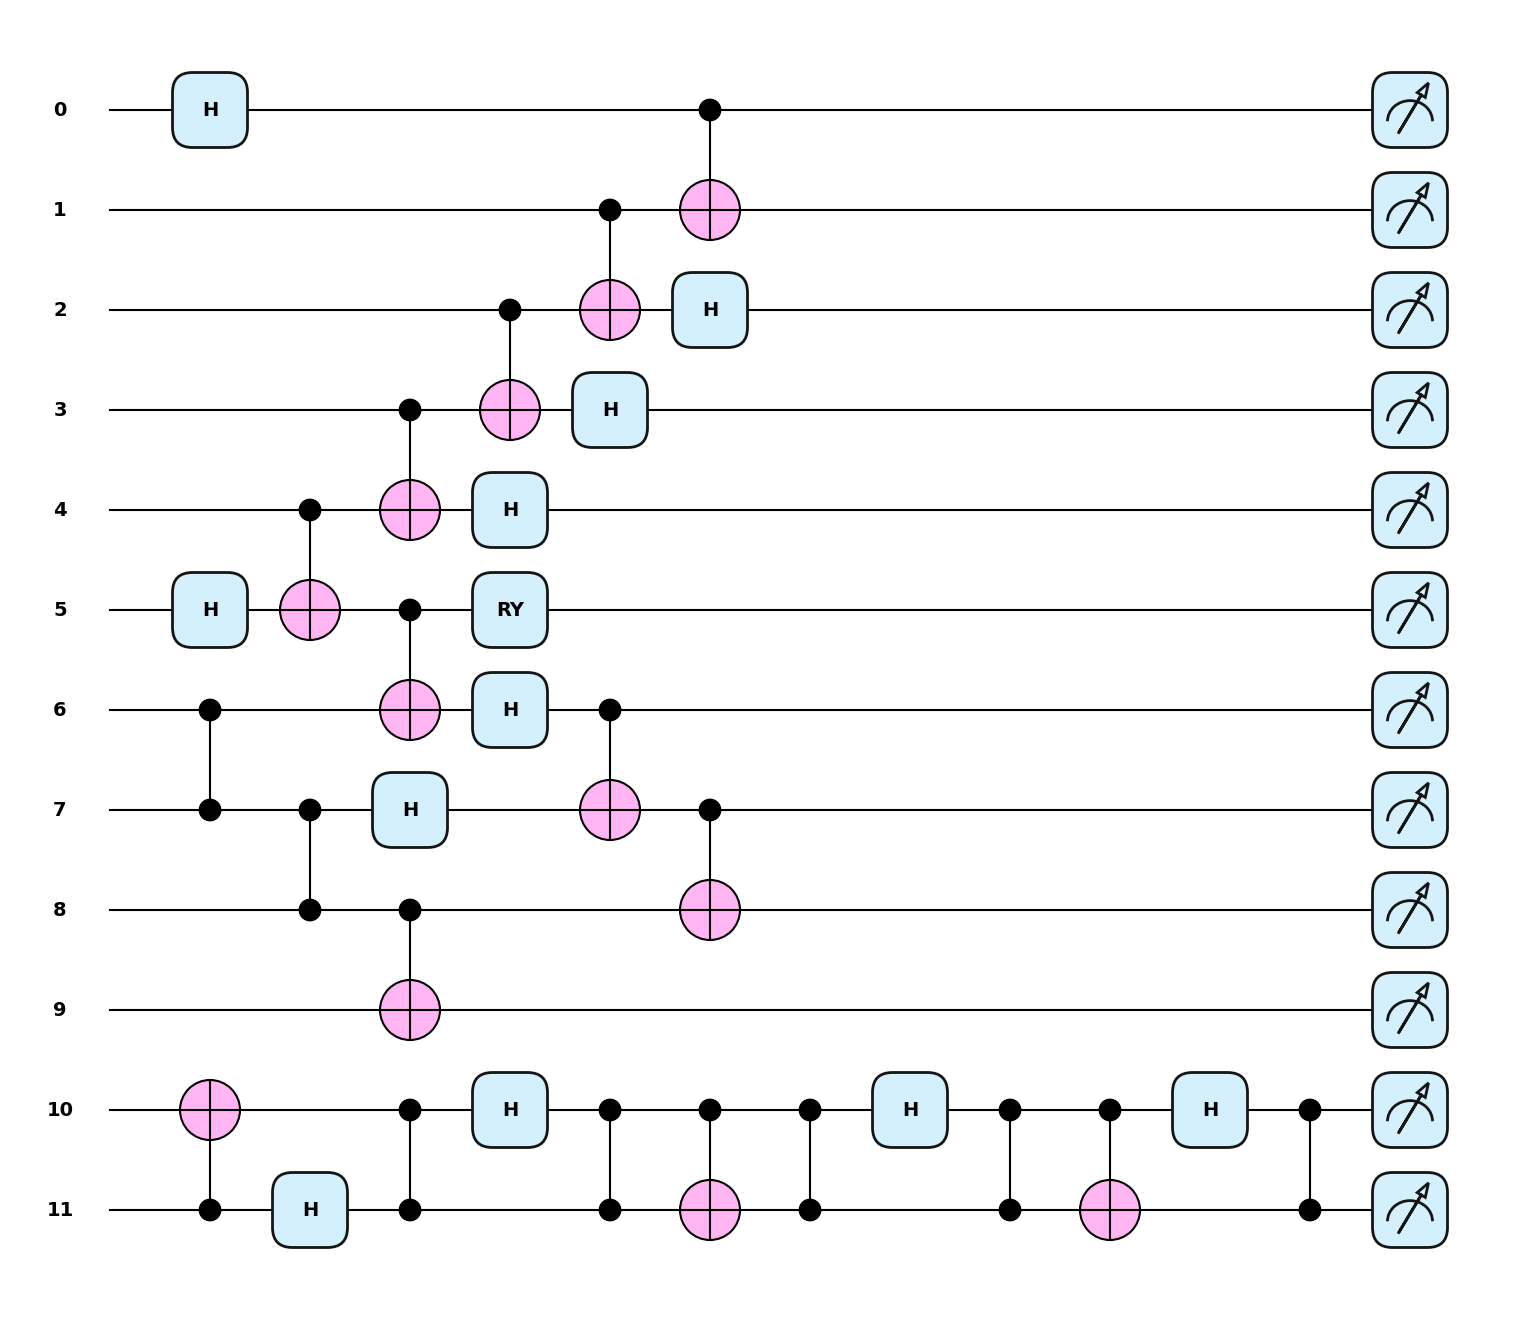

In [3]:
# example
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

show_circuit(circuit)
show_circuit(optimization_level_2(circuit)) # 2-qubit gates
show_circuit(optimization_level_1(optimization_level_2(circuit))) # 1-qubit gates
show_circuit(optimization_level_3(optimization_level_1(optimization_level_2(circuit)))) # 1- and 2-qubit gates

In [4]:
make_spec_table_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)

,Original,Qiskit,PennyLane,Levels 2+1
gates,141,37,37,31
1q gates,116,18,18,12
2q gates,25,19,19,19
depth,32,16,16,12
gate types,5,4,4,4


In [5]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        df = make_spec_table_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)
        dfs.append(df)
    except:
        pass

In [6]:
len(dfs)                                    

1000

In [7]:
dfs[0]

,Original,Qiskit,PennyLane,Levels 2+1
gates,141,37,37,31
1q gates,116,18,18,12
2q gates,25,19,19,19
depth,32,16,16,12
gate types,5,4,4,4


In [8]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,PennyLane,Levels 2+1
gates,0.262,0.262,0.220
1q gates,0.155,0.155,0.103
2q gates,0.760,0.760,0.760
depth,0.500,0.500,0.375
gate types,0.800,0.800,0.800


In [9]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

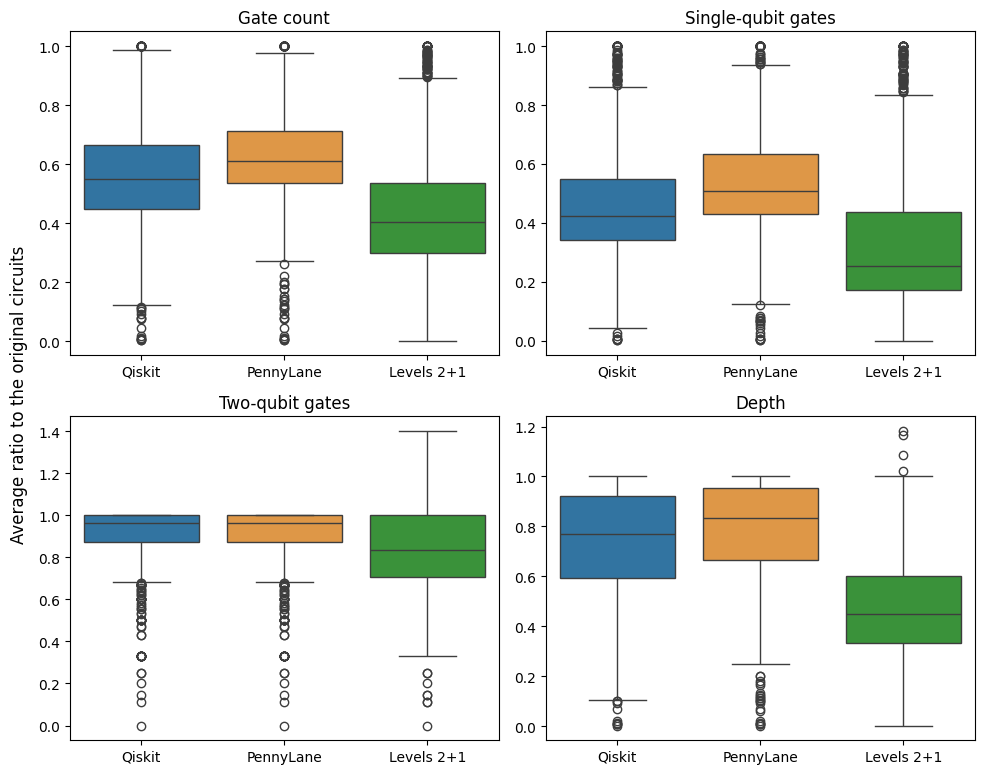

In [10]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8))
for i, metric in enumerate(['gates', '1q gates', '2q gates','depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': "#f7992e", 'Levels 2+1': '#2ca02c'}) # 'Qiskit\n(pattern matching)':'#7b1fb4', 'PennyLane': '#ff7f0e'
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    elif i==3:
        ax.set_title('Depth')
    ax.set_xlabel('') 
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [11]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,Levels 2+1,1q gates,0.342793,0.241721,65.720700
1,Levels 2+1,2q gates,0.813628,0.174052,18.637219
2,Levels 2+1,depth,0.481164,0.208352,51.883600
3,Levels 2+1,gate types,1.263652,0.289969,-26.365200
4,Levels 2+1,gates,0.447711,0.210899,55.228900
5,PennyLane,1q gates,0.546539,0.192436,45.346100
6,PennyLane,2q gates,0.907309,0.140327,9.269091
7,PennyLane,depth,0.784250,0.207323,21.575000
8,PennyLane,gate types,0.974251,0.070722,2.574900
9,PennyLane,gates,0.626431,0.169255,37.356900
